<br />
<div style="text-align: center;">
    <span style="font-weight: bold; color:#6dc; font-family: 'Arial'; font-size: 2.5em;">Tropical and Temperate Rainfall Dataset, Climate Hazard<br /><br /> InfraRed Precipitation with Stations: CHIRPS (USGS,<br /><br /> USAID, NASA, NOAA)<br /></span>
</div>

In [58]:
import pandas as pd
import numpy as np
from os.path import basename, dirname, exists
import os
import rasterio
import glob
import urllib2
import gzip
import shutil
from contextlib import closing
from netCDF4 import Dataset
import datetime

In [59]:
now = datetime.datetime.now()
year = now.year

remote_path = 'ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CHIRPS-2.0/global_daily/tifs/p05/'+str(year)+'/'
print year
print remote_path

local_path = os.getcwd()

2017
ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CHIRPS-2.0/global_daily/tifs/p05/2017/


In [60]:
now = datetime.datetime.now()
year = now.year

remote_path = 'ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CHIRPS-2.0/global_daily/tifs/p05/'+str(year)+'/'
print year
print remote_path

local_path = os.getcwd()

listing = []
response = urllib2.urlopen(remote_path)
for line in response:
    listing.append(line.rstrip())

s2=pd.DataFrame(listing)
s3=s2[0].str.split()
s4=s3[len(s3)-1]
last_file = s4[8]
print 'The last file (compress) is: ',last_file

uncompressed = os.path.splitext(last_file)[0]

print 'The last file UNCOMPRESSED is: ',uncompressed

The last file (compress) is:  chirps-v2.0.2017.05.31.tif.gz
The last file UNCOMPRESSED is:  chirps-v2.0.2017.05.31.tif


In [61]:
with closing(urllib2.urlopen(remote_path+str(last_file))) as r:
    with open(str(last_file), 'wb') as f:
        shutil.copyfileobj(r, f)
        
#uncompress file

archives = [x for x in os.listdir(local_path) if '.gz' in x]

for i, archive in enumerate(archives):
    archive = os.path.join(local_path, archive)
    dest = os.path.join(local_path, os.path.splitext(archive)[0]) # drop the .gz from the filename

    with gzip.open(archive, "rb") as zip:
        with open(dest, "w") as out:
            for line in zip:
                out.write(line)

uncompressed = os.path.splitext(last_file)[0]
os.remove(last_file)

Source:  <open RasterReader name='chirps-v2.0.2017.05.31.tif' mode='r'>
Source mode:  r
.TIF Shape:  (2000, 7200)
Source type: ('float32',)
CRS({'init': u'epsg:4326'})
[-180.0, 0.05000000074505806, 0.0, 50.0, 0.0, -0.05000000074505806]


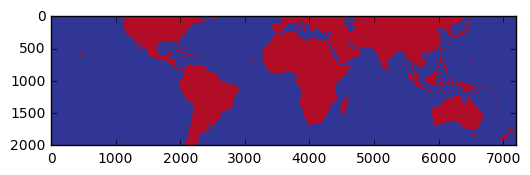

In [62]:
src = rasterio.open(uncompressed)
print 'Source: ',src
print 'Source mode: ',src.mode

array = src.read(1)
print '.TIF Shape: ',array.shape

print 'Source type:',src.dtypes
print(src.crs)
print(src.transform)

from matplotlib import pyplot
pyplot.imshow(array, cmap='RdYlBu_r')

pyplot.show()

In [63]:
with rasterio.open(uncompressed) as src:
    npixels = src.width * src.height
    for i in src.indexes:
        band = src.read(i)
        print(i, band.min(), band.max(), band.sum()/npixels)

(1, -9999.0, 305.68616, -7319.0331733333333)


In [64]:
CM_IN_FOOT = 30.48


with rasterio.open(uncompressed) as src:
    kwargs = src.meta
    kwargs.update(
        driver='GTiff',
        dtype=rasterio.float64,  #rasterio.int16, rasterio.int32, rasterio.uint8,rasterio.uint16, rasterio.uint32, rasterio.float32, rasterio.float64
        count=1,
        compress='lzw',
        nodata=0,
        bigtiff='NO' 
    )

    windows = src.block_windows(1)

    with rasterio.open('chirps.tif','w',**kwargs) as dst:
        for idx, window in windows:
            src_data = src.read(1, window=window)

            # Source nodata value is a very small negative number
            # Converting in to zero for the output raster
            np.putmask(src_data, src_data < 0, 0)

            dst_data = (src_data * CM_IN_FOOT).astype(rasterio.float64)
            dst.write_band(1, dst_data, window=window)
os.remove(uncompressed)

Source:  <open RasterReader name='./chirps.tif' mode='r'>
Source mode:  r
.TIF Shape:  (2000, 7200)
Source type: ('float64',)
CRS({'init': u'epsg:4326'})
[-180.0, 0.05000000074505806, 0.0, 50.0, 0.0, -0.05000000074505806]


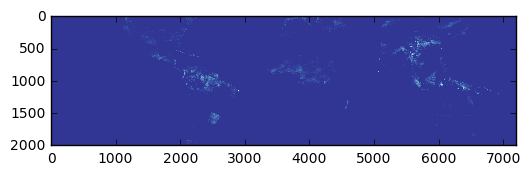

In [65]:
src = rasterio.open('./chirps.tif')
print 'Source: ',src
print 'Source mode: ',src.mode

array = src.read(1)
print '.TIF Shape: ',array.shape

print 'Source type:',src.dtypes
print(src.crs)
print(src.transform)

from matplotlib import pyplot
pyplot.imshow(array, cmap='RdYlBu_r')

pyplot.show()

In [ ]:
import tinys3

conn = tinys3.Connection('S3_ACCESS_KEY','S3_SECRET_KEY',tls=True)

f = open('chirps.tif','rb')
conn.upload('chirps.tif',f,'BUCKET')

In [57]:
pd.__version__

u'0.20.1'

<br />
<div style="text-align: left;">
    <span style="font-weight: bold; color:#6dc; font-family: 'Arial'; font-size: 2.5em;">To Github<br /></span>
</div>

In [76]:
import numpy as np
import pandas as pd
import os
import rasterio
import urllib2
import shutil
from contextlib import closing
from netCDF4 import Dataset
import datetime
import tinys3
np.set_printoptions(threshold='nan')

In [77]:
def dataDownload(): 
    
    now = datetime.datetime.now()
    year = now.year

    remote_path = 'ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CHIRPS-2.0/global_daily/tifs/p05/'+str(year)+'/'
    print year
    print remote_path

    local_path = os.getcwd()

    listing = []
    response = urllib2.urlopen(remote_path)
    for line in response:
        listing.append(line.rstrip())

    s2=pd.DataFrame(listing)
    s3=s2[0].str.split()
    s4=s3[len(s3)-1]
    last_file = s4[8]
    print 'The last file (compress) is: ',last_file

    uncompressed = os.path.splitext(last_file)[0]

    print 'The last file UNCOMPRESSED is: ',uncompressed

    with closing(urllib2.urlopen(remote_path+str(last_file))) as r:
        with open(str(last_file), 'wb') as f:
            shutil.copyfileobj(r, f)

    #uncompress file

    archives = [x for x in os.listdir(local_path) if '.gz' in x]

    for i, archive in enumerate(archives):
        archive = os.path.join(local_path, archive)
        dest = os.path.join(local_path, os.path.splitext(archive)[0]) # drop the .gz from the filename

        with gzip.open(archive, "rb") as zip:
            with open(dest, "w") as out:
                for line in zip:
                    out.write(line)

    uncompressed = os.path.splitext(last_file)[0]
    os.remove(last_file)

    
    return uncompressed

In [81]:
def tiffile(dst,outFile):
    
    
    CM_IN_FOOT = 30.48


    with rasterio.open(file) as src:
        kwargs = src.meta
        kwargs.update(
            driver='GTiff',
            dtype=rasterio.float64,  #rasterio.int16, rasterio.int32, rasterio.uint8,rasterio.uint16, rasterio.uint32, rasterio.float32, rasterio.float64
            count=1,
            compress='lzw',
            nodata=0,
            bigtiff='NO' 
        )

        windows = src.block_windows(1)

        with rasterio.open(outFile,'w',**kwargs) as dst:
            for idx, window in windows:
                src_data = src.read(1, window=window)

                # Source nodata value is a very small negative number
                # Converting in to zero for the output raster
                np.putmask(src_data, src_data < 0, 0)

                dst_data = (src_data * CM_IN_FOOT).astype(rasterio.float64)
                dst.write_band(1, dst_data, window=window)
    os.remove('./'+file)

In [82]:
def s3Upload(outFile):
    # Push to Amazon S3 instance
    conn = tinys3.Connection(os.getenv('S3_ACCESS_KEY'),os.getenv('S3_SECRET_KEY'),tls=True)
    f = open(outFile,'rb')
    conn.upload(outFile,f,os.getenv('BUCKET'))

In [83]:
# Execution
outFile = 'chirps.tiff'

print 'starting'
file = dataDownload()
print 'downloaded'
tiffile(file,outFile)
print 'converted'
#s3Upload(outFile)
print 'finish'

starting
2017
ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CHIRPS-2.0/global_daily/tifs/p05/2017/
The last file (compress) is:  chirps-v2.0.2017.05.31.tif.gz
The last file UNCOMPRESSED is:  chirps-v2.0.2017.05.31.tif
downloaded
converted
finish
